## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

import matplotlib.patches as patches

/Users/rok/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import spark_fof
reload(spark_fof)
from spark_fof import Particle, groupID, DomainRectangle, get_rectangle_bin, get_bin, set_local_group

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)

## Set up data

In [4]:
data = []
data.append(Particle(-.35,-.35,0,groupID(1,1)))
data.append(Particle(-.27,-.27,1,groupID(1,1)))
data.append(Particle(-.23,-.23,2,groupID(1,1)))
data.append(Particle(-.19,-.19,3,groupID(1,1)))
data.append(Particle(-.01,-.01,4,groupID(1,1)))
data.append(Particle(0.01,0.01,5,groupID(1,1)))
data.append(Particle(0.23,0.23,6,groupID(1,1)))
data.append(Particle(0.29,0.29,7,groupID(1,1)))
data.append(Particle(0.49,0.49,8,groupID(1,1)))
data.append(Particle(0.51,0.51,9,groupID(1,1)))

## Start Spark

In [5]:
import findspark
findspark.init()

In [6]:
import pyspark
from pyspark import SparkContext

In [7]:
sc = SparkContext(master='local[4]')

In [8]:
sc.addPyFile('spark_fof.py')

## Set up the domains

In [9]:
N = 3
tau = 0.05
mins = [-1,-1]
maxes= [1,1]
domain_containers = spark_fof.setup_domain(N,tau)

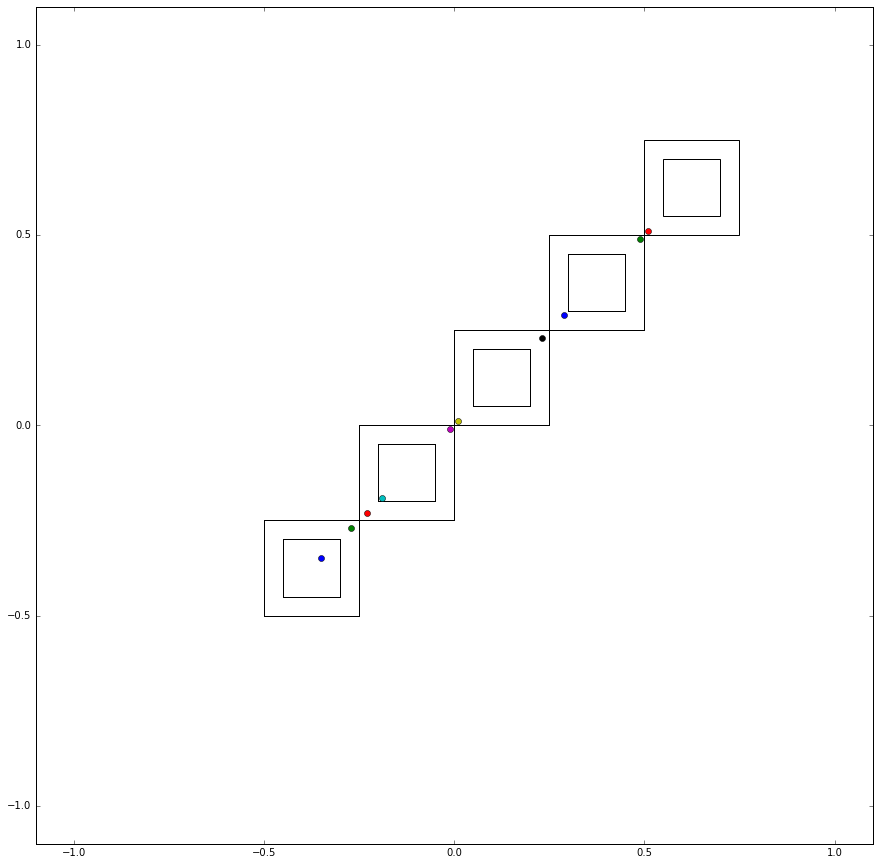

In [10]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in data: 
    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)], ax=ax)
    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)].bufferRectangle, ax=ax)
    ax.plot(p.x, p.y, 'o')

### Make the base RDD

In [11]:
p_rdd = sc.parallelize(data)

In [12]:
p_rdd.collect()

[x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=1),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=1),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=1),
 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=1),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=1),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=1),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=1),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=1),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=1),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=1)]

### Partition particles into domains and set the partition part of local group ID

In [13]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers))
                 .values()
                 .mapPartitionsWithIndex(set_local_group))

#### Check the partitioned RDD -- some of the particles will be duplicated

In [14]:
parts = part_rdd.collect()

In [15]:
for i,p in enumerate(parts): 
    print i, p

0 x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=18)
1 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18)
2 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=19)
3 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=19)
4 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=26)
5 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=26)
6 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=27)
7 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=27)
8 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=27)
9 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=28)
10 x=0.01 y=0.01 pid=5 gid=(id=1 cid=28)
11 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=35)
12 x=0.01 y=0.01 pid=5 gid=(id=1 cid=35)
13 x=0.01 y=0.01 pid=5 gid=(id=1 cid=36)
14 x=0.23 y=0.23 pid=6 gid=(id=1 cid=36)
15 x=0.23 y=0.23 pid=6 gid=(id=1 cid=37)
16 x=0.29 y=0.29 pid=7 gid=(id=1 cid=37)
17 x=0.23 y=0.23 pid=6 gid=(id=1 cid=44)
18 x=0.29 y=0.29 pid=7 gid=(id=1 cid=44)
19 x=0.29 y=0.29 pid=7 gid=(id=1 cid=45)
20 x=0.49 y=0.49 pid=8 gid=(id=1 cid=45)
21 x=0.49 y=0.49 pid=8 gid=(id=1 cid=46)
22 x=0.51 y=0.51 pid=9 gid=(id=1 cid=46)
23 x=0.49 y=0.49 pid=8 gid=(id=1 cid=53)
24 x

### Group Merging stage

#### Ugly hack to create a 'fake' data set to look like what we would get out of a first FOF pass

In [16]:
data_partitions = []
for p in parts: 
    data_partitions.append(p.gid.partition)

In [17]:
fof_rdd = sc.parallelize(zip(data_partitions, parts)).partitionBy(len(domain_containers)).values()

In [18]:
mappings_list = []

In [19]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd)

In [24]:
merged_rdd = fof_analyzer.merge_groups(3)

In [25]:
merged_rdd.collect()

[x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=18),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=18),
 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=18),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=18),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=18),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=18),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=18),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=18),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=18),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=18),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=18),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=18),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=18),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=18),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=18),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=18),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=18),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=18),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=18),
 x=0.51 y=0.51 pid

In [23]:
fof_analyzer.particle_rdd.collect()

[x=-0.35 y=-0.35 pid=0 gid=(id=1 cid=18),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=18),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=19),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=19),
 x=-0.27 y=-0.27 pid=1 gid=(id=1 cid=26),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=26),
 x=-0.23 y=-0.23 pid=2 gid=(id=1 cid=27),
 x=-0.19 y=-0.19 pid=3 gid=(id=1 cid=27),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=27),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=28),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=28),
 x=-0.01 y=-0.01 pid=4 gid=(id=1 cid=35),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=35),
 x=0.01 y=0.01 pid=5 gid=(id=1 cid=36),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=36),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=37),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=37),
 x=0.23 y=0.23 pid=6 gid=(id=1 cid=44),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=44),
 x=0.29 y=0.29 pid=7 gid=(id=1 cid=45),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=45),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=46),
 x=0.51 y=0.51 pid=9 gid=(id=1 cid=46),
 x=0.49 y=0.49 pid=8 gid=(id=1 cid=53),
 x=0.51 y=0.51 pid